In [34]:
#Survey Alphafold PLDDT scores and plot by orthogroup.  
import os
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from collections import Counter
%load_ext autoreload
%autoreload 2
import diverse_yeast_tools as dyt

import json

base_dir = os.path.normpath('G:/My Drive/Crick_LMS/projects/diverse_yeasts')

y1000plus_dir = os.path.normpath('C:/Users/heineib/Documents/GitHub/y1000plus_tools/data') + os.sep

#Load y1000 species table
y1000_species = pd.read_csv(y1000plus_dir + os.path.normpath("y1000plus_tools_data/y1000plus/y1000_species_table.csv"), index_col=0)

#fig2_orig_genome_lookup = dict(zip(y1000_species['species_names_fig2'], y1000_species['original_genome_id']))
orig_genome_lookup = dict(zip(y1000_species['original_genome_id'],y1000_species['old_species_names']))

with open(base_dir + os.sep + 'alphafold' + os.sep + 'og_metadata.json', 'r') as f:
    og_metadata = json.load(f)



In [3]:
score_table = pd.read_table(base_dir + os.sep + 'alphafold' + os.sep + 'selected_proteins_progress.tsv')

In [4]:
new_score = []
for score in score_table['Plddt']:
    if score == '-': 
        new_score.append(0)
    else:
        new_score.append(float(score))
        
score_table['Plddt_0_rep'] = new_score

In [5]:
#Add name from the sequence MSAs
seq_aln_names = []
for name in score_table['ID']:
    (old_name, og, y1000_id) = name.split('__')
    seq_aln_names.append(orig_genome_lookup[old_name] + '|' + y1000_id)

score_table['ID_seq_aln'] = seq_aln_names


In [6]:
score_table

,ID,species,OG,Plddt,Plddt_0_rep,ID_seq_aln
0,alloascoidea_hylecoeti__OG1004__0_1963,alloascoidea,OG1004,79.9559,79.9559,Alloascoidea_hylecoeti|0_1963
1,alloascoidea_hylecoeti__OG1004__0_887,alloascoidea,OG1004,69.6685,69.6685,Alloascoidea_hylecoeti|0_887
2,alloascoidea_hylecoeti__OG1004__0_8918,alloascoidea,OG1004,75.0749,75.0749,Alloascoidea_hylecoeti|0_8918
3,alloascoidea_hylecoeti__OG1004__0_9006,alloascoidea,OG1004,74.7122,74.7122,Alloascoidea_hylecoeti|0_9006
4,alloascoidea_hylecoeti__OG1004__0_9052,alloascoidea,OG1004,85.0866,85.0866,Alloascoidea_hylecoeti|0_9052
...,...,...,...,...,...,...
10635,zygosaccharomyces_rouxii__OG6290__342_1547,zygosaccharomyces,OG6290,-,0.0000,Zygosaccharomyces_rouxii|342_1547
10636,zygosaccharomyces_rouxii__OG6574__342_722,zygosaccharomyces,OG6574,-,0.0000,Zygosaccharomyces_rouxii|342_722
10637,zygosaccharomyces_rouxii__OG6598__342_4556,zygosaccharomyces,OG6598,-,0.0000,Zygosaccharomyces_rouxii|342_4556
10638,zygosaccharomyces_rouxii__OG7278__342_638,zygosaccharomyces,OG7278,-,0.0000,Zygosaccharomyces_rouxii|342_638


Text(0.5, 1.0, 'Histogram of PLDDT Scores for Calculated Structures')

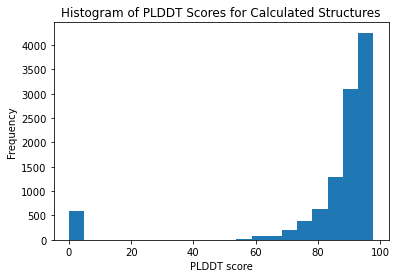

In [26]:
fig, ax = plt.subplots()

ax.hist(score_table['Plddt_0_rep'], bins = 20)
ax.set_xlabel('PLDDT score')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of PLDDT Scores for Calculated Structures')

In [62]:
#For each OG, for the peptides that are calculated, calculate Mean and Var

#Scatter of Mean vs Var of PLDDT score, with color as percentage that is not calculate

peptides_calculated = score_table.loc[score_table['Plddt_0_rep']>0,:].copy()
peptides_calculated_grouped = peptides_calculated.groupby('OG')
peptides_not_calculated = score_table.loc[score_table['Plddt_0_rep']==0,:].copy()
print(str(len(peptides_not_calculated)) + ' structures that could not be calculated')

all_og_counts = Counter(score_table['OG'])
og_blank_counts = Counter(peptides_not_calculated['OG'])

og_plddt_dict = {}

for og in list(set(score_table['OG'])):
    #(plddt_mean, plddt_var, N_tot, N_not_calc, pct_not_calc, sc_names, pathway_name)
    if og in set(peptides_calculated['OG']):
        plddt_mean = peptides_calculated_grouped.mean().loc[og,'Plddt_0_rep']
        plddt_std = peptides_calculated_grouped.std().loc[og,'Plddt_0_rep']
    else:
        plddt_mean = 0
        plddt_std = 0
    
    N_tot = all_og_counts[og]
    if og in og_blank_counts.keys(): 
        N_not_calc = og_blank_counts[og]
    else: 
        N_not_calc = 0
    pct_not_calc = N_not_calc/N_tot
    sc_names = og_metadata[og]['sc_names']
    pathway_name = og_metadata[og]['pathways_name']
    
    og_plddt_dict[og] = (plddt_mean, plddt_std, N_tot, N_not_calc, pct_not_calc, sc_names, pathway_name)
    

og_plddt_table = pd.DataFrame.from_dict(og_plddt_dict, orient = 'index', columns = ['plddt_mean', 'plddt_std', 'N_tot', 'N_not_calc', 'pct_not_calc', 'sc_names', 'pathway_name'])

og_plddt_table.sort_values('N_not_calc', ascending=False, inplace=True)

591 structures that could not be calculated


Text(0, 0.5, 'Std of Plddt for OG')

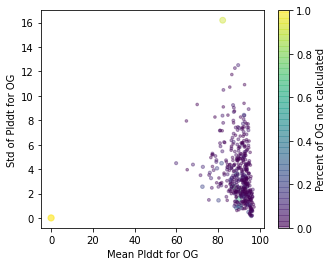

In [54]:
fig, ax = plt.subplots(figsize = (5,4))

im = ax.scatter(og_plddt_table['plddt_mean'], og_plddt_table['plddt_std'], alpha = 0.4, c = og_plddt_table['pct_not_calc'], s = 30*og_plddt_table['pct_not_calc'] + 7 )
fig.colorbar(im, ax=ax, label = 'Percent of OG not calculated')
ax.set_xlabel('Mean Plddt for OG')
ax.set_ylabel('Std of Plddt for OG')


In [58]:
peptides_not_calculated.sort_values('OG', inplace=True)

In [61]:
#og_plddt_table.to_csv(base_dir + os.sep + 'alphafold' + os.sep + 'og_plddt_data.csv')
peptides_not_calculated.to_csv(base_dir + os.sep + 'alphafold' + os.sep + 'failed_structures.csv')

In [4]:
#Add Uniprot Names to Peptides not calculated

peptides_not_calculated = pd.read_csv(base_dir + os.sep + 'alphafold' + os.sep + 'failed_structures.csv', index_col=0)

In [35]:
#Load original sequence file, and make dictionary of gene_id to fasta header and gene_id to peptide sequence
#Read in Sequence File, extract all names make dict of seq_alignment sequences
selected_proteins = SeqIO.parse(base_dir +os.sep +'alphafold' + os.sep +   'selected_proteins.fasta', 'fasta')
selected_proteins_headers = {}
selected_proteins_seqs = {}
for record in selected_proteins: 
    selected_proteins_headers[record.id] = record.description
    selected_proteins_seqs[record.id] = str(record.seq)

#Load peptide sequences for model species, make dictionary from gene id to peptide sequence
model_protein_dict = {}
for spec_abbrev in ['Scer', 'Spom', 'Calb']: 
    model_protein_dict[spec_abbrev] = dyt.load_model_protein_dict(spec_abbrev)
    

In [ ]:
uniprot_id = []
seq_len = []
for ind, (name_orig, spec_table, og, plddt, plddt_0_rep, id_seq_aln) in peptides_not_calculated.iterrows():
    structure_imported=False
    #Check if name in ref sequence (S.cer, C.alb, and S. pom) + convert
    if name_orig.split('_')[0] in set(['Scer', 'REF', 'Calb', 'Spom']):
        structure_imported = True
        if name_orig.split('_')[0] == 'REF': 
            spec_abbrev = name_orig.split('_')[1]
            swissprot_id = name_orig.split('_')[2].split('-')[1]
        else: 
            spec_abbrev = name_orig.split('_')[0]
            swissprot_id = name_orig.split('_')[1].split('-')[1]

        (spec) = modelspec_params[spec_abbrev]
        gene_id = swissprot_id_2_gene_id[spec_abbrev][swissprot_id]
        if spec_abbrev == 'Spom':
            y1000_id = 'None'
        else: 
            #spec_old = spec_abbrev_dict[spec_abbrev]
            y1000_id = gene_id_2_y1000_id[spec_abbrev][gene_id]

    else: 
        (spec, og, y1000_id) = name_orig.split('__')


    #Filter by structural clusters within OGs based on Nir's analysis
    #if name_orig in seqs_to_include: 

    #Extract sequence from original peptide fasta

    if structure_imported: 
        prot_seq = model_protein_dict[spec_abbrev][gene_id]
        L = len(prot_seq)
        #header = '>' + name_orig + ' source=af2  gene_full=' + gene_id +' y1000_id=' + y1000_id + ' L=' + str(L) + '\n' 

        #proteins_present_by_spec[spec].append((name_orig,gene_id,y1000_id,swissprot_id,'af2'))


    else: 
        header_dict = {}
        header_raw =selected_proteins_headers[name_orig] 
        for item in header_raw.split(' ')[1:]: 
            key,val = item.split('=')
            header_dict[key] = val

        source = header_dict['source']
        if source=='uniprot':
            swissprot_id = header_dict['gene_full'].split('|')[1]
        elif source=='shen':
            swissprot_id = None

        #proteins_present_by_spec[spec].append((name_orig,None,y1000_id,swissprot_id, source))

        prot_seq = selected_proteins_seqs[name_orig]
        L = len(prot_seq)
        #header = '>' + header_raw + '\n'  
    
    uniprot_id.append(swissprot_id)
    seq_len.append(L)

peptides_not_calculated['seq_len'] = seq_len
peptides_not_calculated['uniprot_id'] = uniprot_id

In [44]:
peptides_not_calculated.to_csv(base_dir + os.sep + 'alphafold' + os.sep + 'failed_structures.csv')